In [1]:
!pip install setuptools==66
!pip install matplotlib_inline
!pip install d2l==1.0.0b

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.1
    Uninstalling setuptools-67.6.1:
      Successfully uninstalled setuptools-67.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# NLI using Attention

• The decomposable attention model consists of three steps for predicting the logical rela- tionships between premises and hypotheses: attending, comparing, and aggregating.

• Withattentionmechanisms,wecanaligntokensinonetextsequencetoeverytokeninthe other, and vice versa. Such alignment is soft using weighted average, where ideally large weights are associated with the tokens to be aligned.

• The decomposition trick leads to a more desirable linear complexity than quadratic com- plexity when computing attention weights.

• We can use pretrained word vectors as the input representation for downstream natural language processing task such as natural language inference.


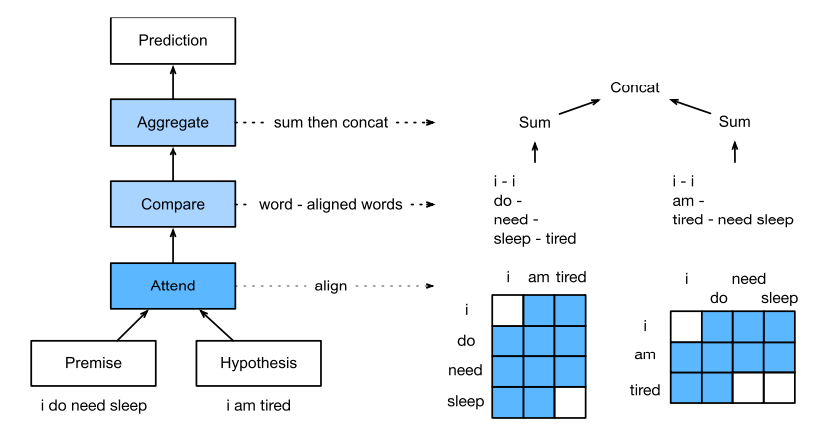

In [3]:
def mlp(num_inputs, num_hiddens, flatten):
  net = []
  net.append(nn.Dropout(0.2))
  net.append(nn.Linear(num_inputs, num_hiddens))
  net.append(nn.ReLU())

  if flatten:
    net.append(nn.Flatten(start_dim = 1))
  
  net.append(nn.Dropout(0.2))
  net.append(nn.Linear(num_hiddens,num_hiddens))

  net.append(nn.ReLU())

  if flatten:
    net.append(nn.Flatten(start_dim = 1))
  
  return nn.Sequential(*net)

In [50]:
# soft alignment of hypotheses (beta) with input premises A 
# and soft alignment of premises (alpha) with input hypotheses B.
class Attend(nn.Module):
  def __init__(self, num_inputs, num_hiddens, **kwargs):
    super(Attend, self).__init__(**kwargs)
    self.f = mlp(num_inputs, num_hiddens, flatten = False)

  def forward(self, A,B):
    #shape of A or B = (batch_size, # of tokens, embed_size)
    #shape of f_A or f_B = (batch_size, # of tokens, embed_size)
    f_A = self.f(A)
    f_B = self.f(B)

    #shape of e ( batch_size, # tokens in A, # tokens in B )
    e = torch.bmm(f_A, f_B.permute(0,2,1))
    #beta shape = (batch_sie, # tokens in A, embed_size)
    beta = torch.bmm(F.softmax(e, dim = -1), B)
    #alpha shape = (batch_size, # tokens in B, embed_size)
    alpha = torch.bmm(F.softmax(e.permute(0,2,1), dim = -1), A)

    return beta, alpha
  
class Compare(nn.Module):
  def __init__(self, num_inputs, num_hiddens, **kwargs):
    super(Compare, self).__init__(**kwargs)
    self.g = mlp(num_inputs, num_hiddens, flatten = False)
  
  def forward(self, A, B, beta, alpha):
    V_A = self.g(torch.cat([A, beta], dim = 2))
    V_B = self.g(torch.cat([B, alpha], dim = 2))

    return V_A, V_B

class Aggregate(nn.Module):
  def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
    super(Aggregate, self).__init__(**kwargs)
    self.h = mlp(num_inputs, num_hiddens, flatten = True)
    self.linear = nn.Linear(num_hiddens, num_outputs)
  
  def forward(self, V_A, V_B):
    V_A = V_A.sum(dim = 1)
    V_B = V_B.sum(dim = 1)
    y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim = 1)))
    return y_hat

class DecomposableAttention(nn.Module):
  def __init__(self, vocab, embed_size, num_hiddens, 
               num_inputs_attend = 100, num_inputs_compare = 200, 
               num_inputs_agg = 400, **kwargs):
    super(DecomposableAttention, self).__init__(**kwargs)
    self.embedding = nn.Embedding(len(vocab), embed_size)
    self.attend = Attend(num_inputs_attend, num_hiddens)
    self.compare = Compare(num_inputs_compare, num_hiddens)
    #num output is 3 because there are 3 type of labels: entailment, contradiction, negation
    self.aggregate = Aggregate(num_inputs_agg, num_hiddens, 3)

  def forward(self, X):
    premises, hypotheses = X
    A = self.embedding(premises)
    B = self.embedding(hypotheses)
    beta, alpha = self.attend(A,B)
    V_A, V_B = self.compare(A, B, beta, alpha)
    Y_hat = self.aggregate(V_A, V_B)

    return Y_hat

# Train and Evaluate

In [35]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]

read 549367 examples
read 9824 examples


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [48]:
# embed size to be the same with GloVe dimension (change it if you want ot use bigger GloVE)
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()

net = DecomposableAttention(vocab, embed_size, num_hiddens)
net.embedding.weight.data.copy_(embeds)

tensor([[ 0.3847,  0.4935,  0.4910,  ...,  0.0263,  0.3905,  0.5222],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        [ 0.9747,  1.2276,  0.4538,  ...,  0.2209,  1.7439, -0.8991],
        ...,
        [-0.0205, -0.4512,  0.6993,  ...,  0.0381,  0.2786,  0.2889],
        [-0.2484, -0.2568,  0.0255,  ...,  0.2161, -0.3413,  0.6266],
        [-0.1438,  0.8681, -0.7219,  ...,  0.0553, -0.4339,  0.3486]])

loss 0.488, train acc 0.809, test acc 0.828
16344.5 examples/sec on [device(type='cuda', index=0)]


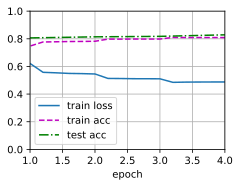

In [51]:
#Train the network
lr, epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr = lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, epochs, devices)

In [53]:
def predict_snli(net, vocab, premise, hypothesis):
  net.eval()
  premise = torch.tensor(vocab[premise], device = d2l.try_gpu())
  hypothesis = torch.tensor(vocab[premise], device = d2l.try_gpu())
  label = torch.argmax(net(
      [premise.reshape((1,-1)), 
       hypothesis.reshape((1,-1))]), 
       dim = 1)

  return 'entailment' if label == 0 else 'contradiction' if label == 1 else 'neutral'

samples = [('he is good', 'he is bad'), ('he is coding', 'he is sleeping'), ('a couple is hugging', 'a couple showing affection')]

for p, h in samples:
  p = p.split(' ')
  h = h.split(' ')
  print(predict_snli(net, vocab, p, h))

neutral
entailment
contradiction


# Questions 


1. Trainthemodelwithothercombinationsofhyperparameters.Canyougetbetteraccuracy on the test set?

2. What are major drawbacks of the decomposable attention model for natural language inference?

3. Suppose that we want to get the level of semantical similarity (e.g., a continuous value between 0 and 1) for any pair of sentences. How shall we collect and label the dataset? Can you design a model with attention mechanisms?